# Examining LAMOST Kepler Gaia crossmatch.

The version of this code used in the paper is implemented in code/data.py.

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

from astropy.io import fits

In [105]:
lamost = pd.read_csv("../data/gaia-kepler-lamost_snr.csv")  # File created using the LAMOST DR5 website: http://dr5.lamost.org/search

Merge Gaia and LAMOST catalogs using RA and dec.

In [108]:
# Load Gaia-Kepler crossmatch.
with fits.open("../data/kepler_dr2_1arcsec.fits") as data:
    gaia = pd.DataFrame(data[1].data, dtype="float64")

Round Gaia ra and dec down to 6 decimal places for the Xmatch.

In [109]:
gaia["ra_6dp"] = np.round(gaia.ra.values, 6)
gaia["dec_6dp"] = np.round(gaia.dec.values, 6)

In [110]:
# Add LAMOST
lamost["ra_6dp"] = lamost.inputobjs_input_ra.values
lamost["dec_6dp"] = lamost.inputobjs_input_dec.values
lamost_gaia = pd.merge(gaia, lamost, on=["ra_6dp", "dec_6dp"], how="left", suffixes=["", "_lamost"])
lamost_gaia = lamost_gaia.drop_duplicates(subset="source_id")

Save the Xmatched catalogue.

In [136]:
# lamost_gaia.to_csv("../data/lamost_gaia_kepler.csv")

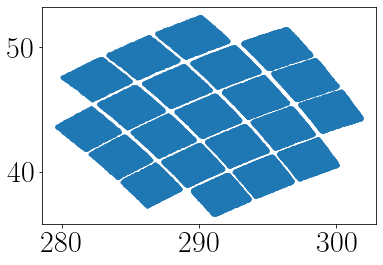

In [113]:
plt.plot(lamost_gaia.ra_6dp, lamost_gaia.dec_6dp, ".")

In [131]:
m = np.isfinite(lamost_gaia.stellar_rv.values)
_m = np.isfinite(lamost_gaia.radial_velocity.values) & (lamost_gaia.radial_velocity.values != 0)
print(f"All stars = {len(lamost_gaia)}, Stars with LAMOST RVs = {sum(m)}, stars with Gaia RVs = {sum(_m)}")

All stars = 196300, Stars with LAMOST RVs = 37949, stars with Gaia RVs = 30276


In [132]:
m = np.isfinite(lamost_gaia.stellar_rv.values) & np.isfinite(lamost_gaia.radial_velocity.values) \
    & (lamost_gaia.radial_velocity.values != 0) & (abs(lamost_gaia.stellar_rv_err.values) < 100)
print(f"Stars with both Gaia and LAMOST RVS = {sum(m)}")

Stars with both Gaia and LAMOST RVS = 12418


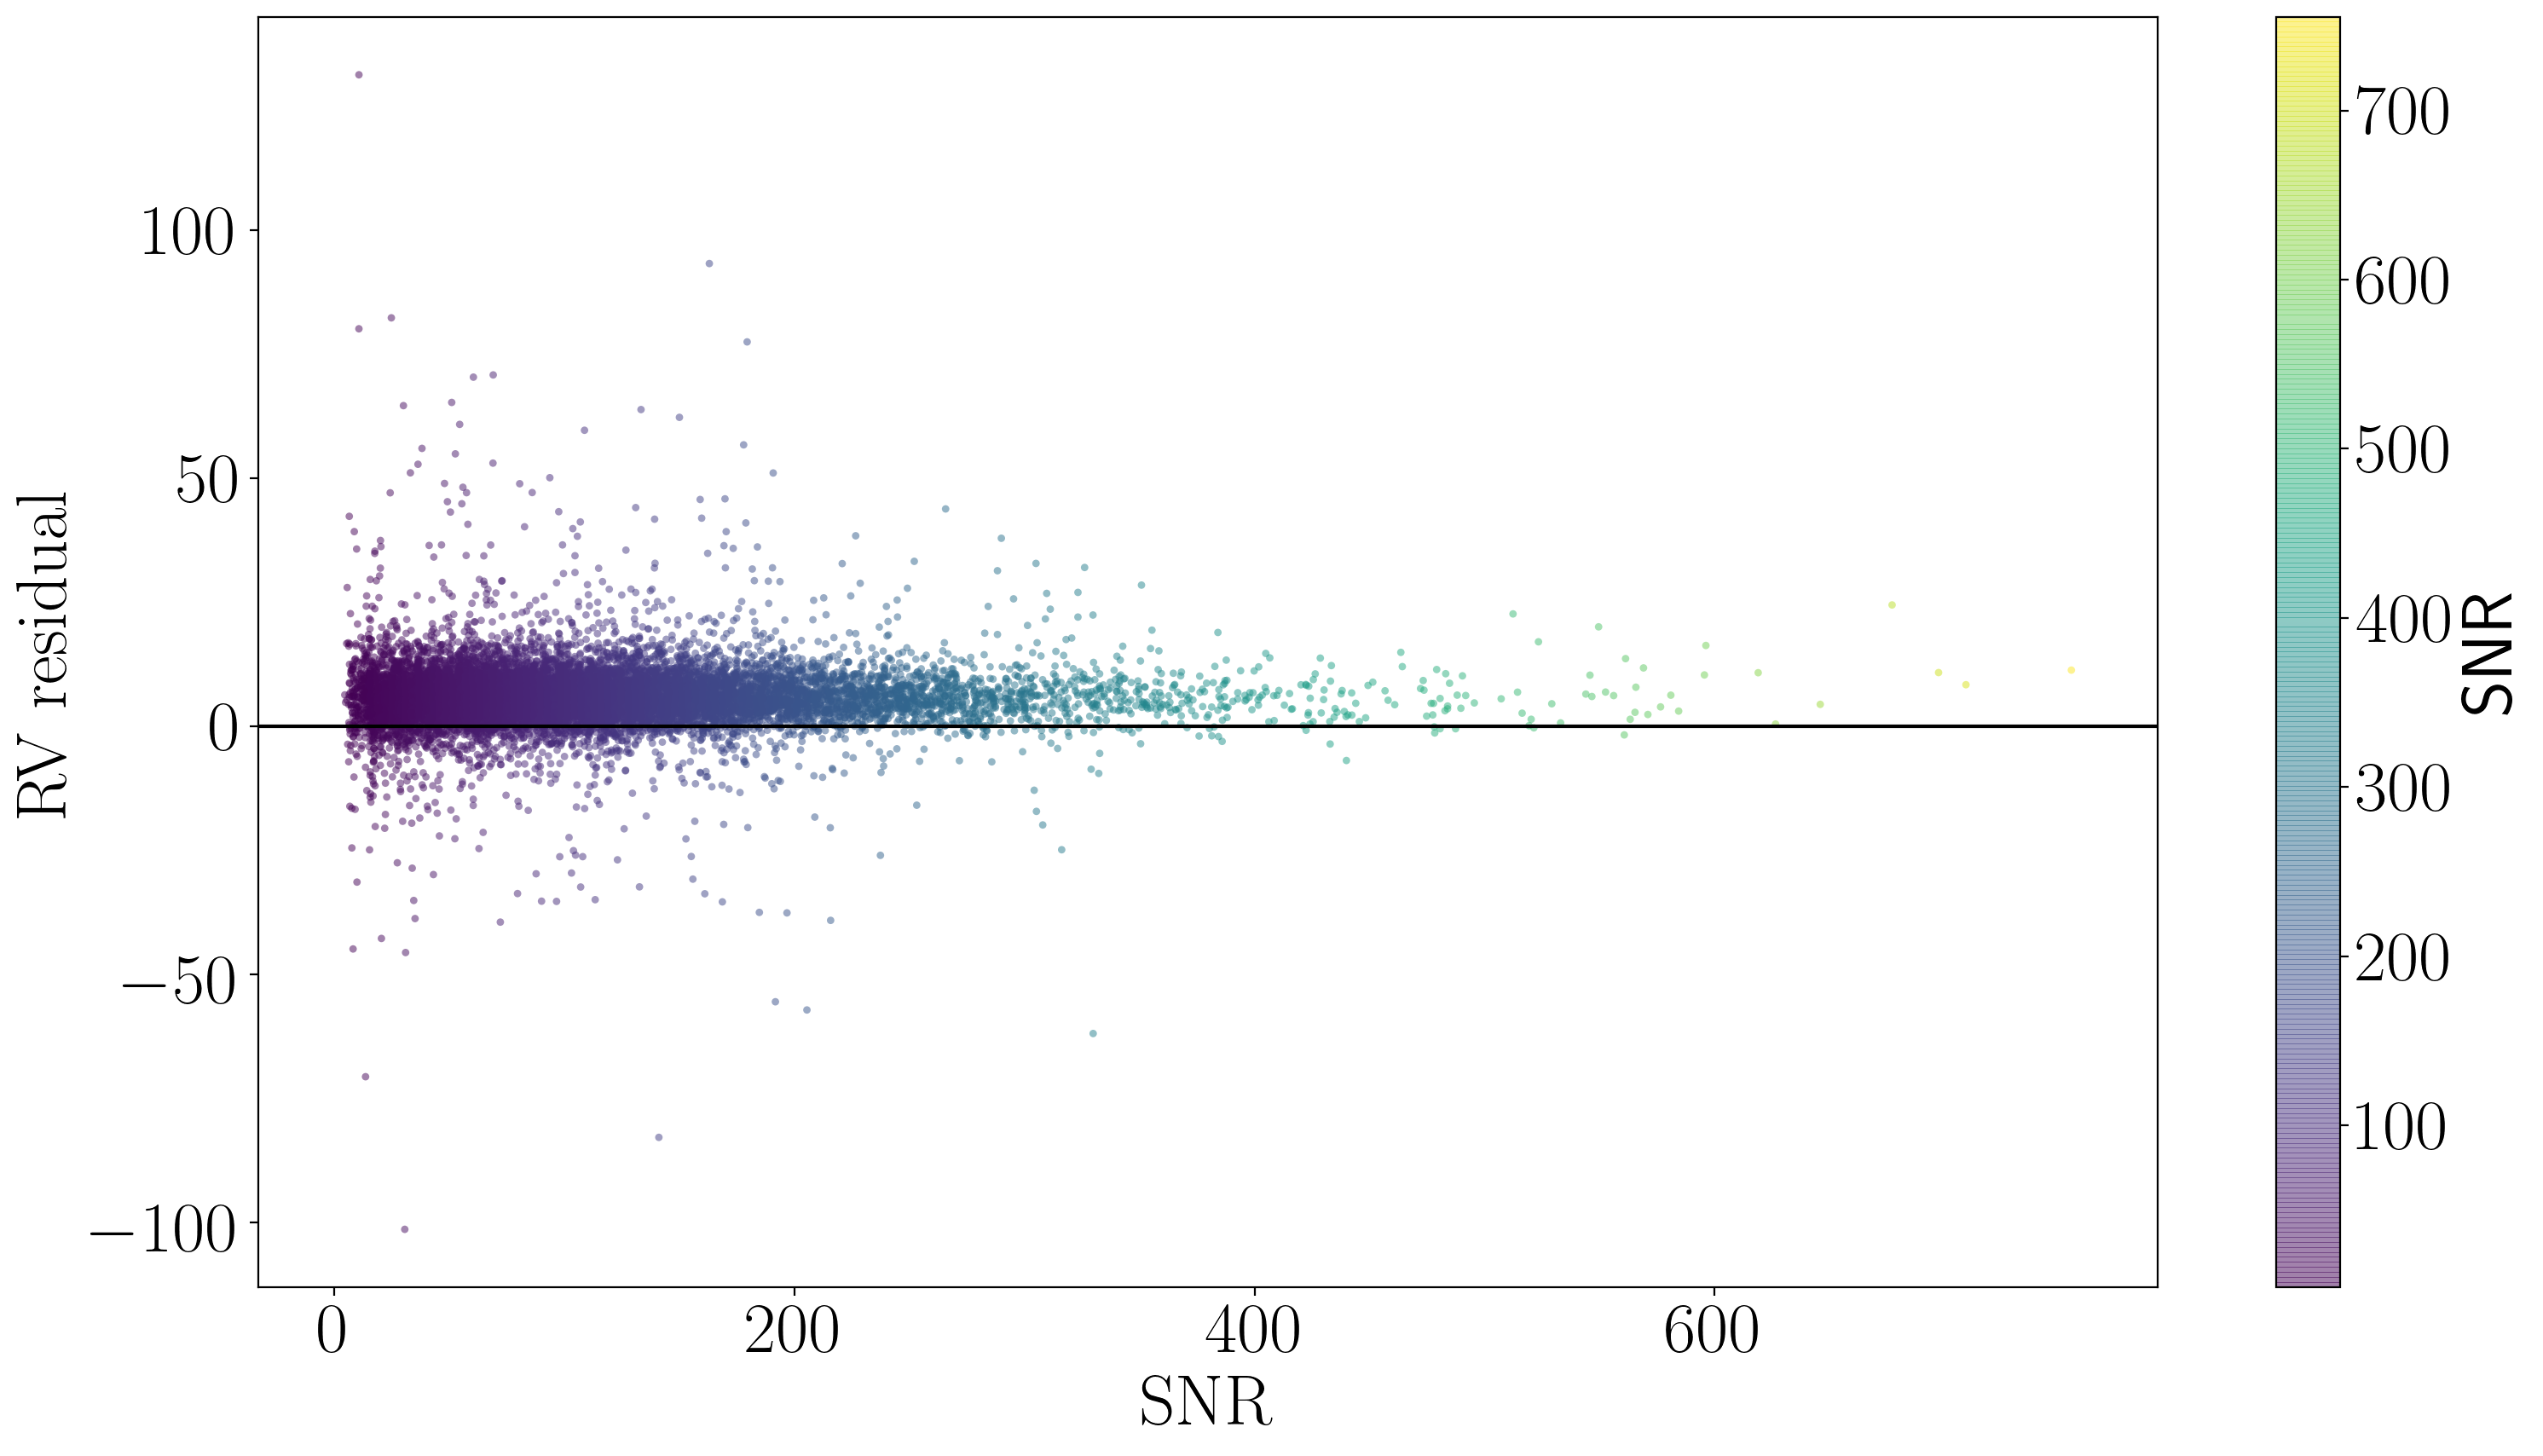

In [133]:
plt.figure(figsize=(16, 9), dpi=200)
plt.scatter(lamost_gaia.catalogue_snrg.values[m], lamost_gaia.radial_velocity.values[m] - lamost_gaia.stellar_rv.values[m],
            c=lamost_gaia.catalogue_snrg.values[m], s=10, alpha=.5, edgecolor="none", zorder=0, rasterized=True)
plt.axhline(0, color="k")
plt.xlabel("$\mathrm{SNR}$")
plt.ylabel("$\mathrm{RV~residual}$")
plt.colorbar(label="SNR")
plt.tight_layout()

12418


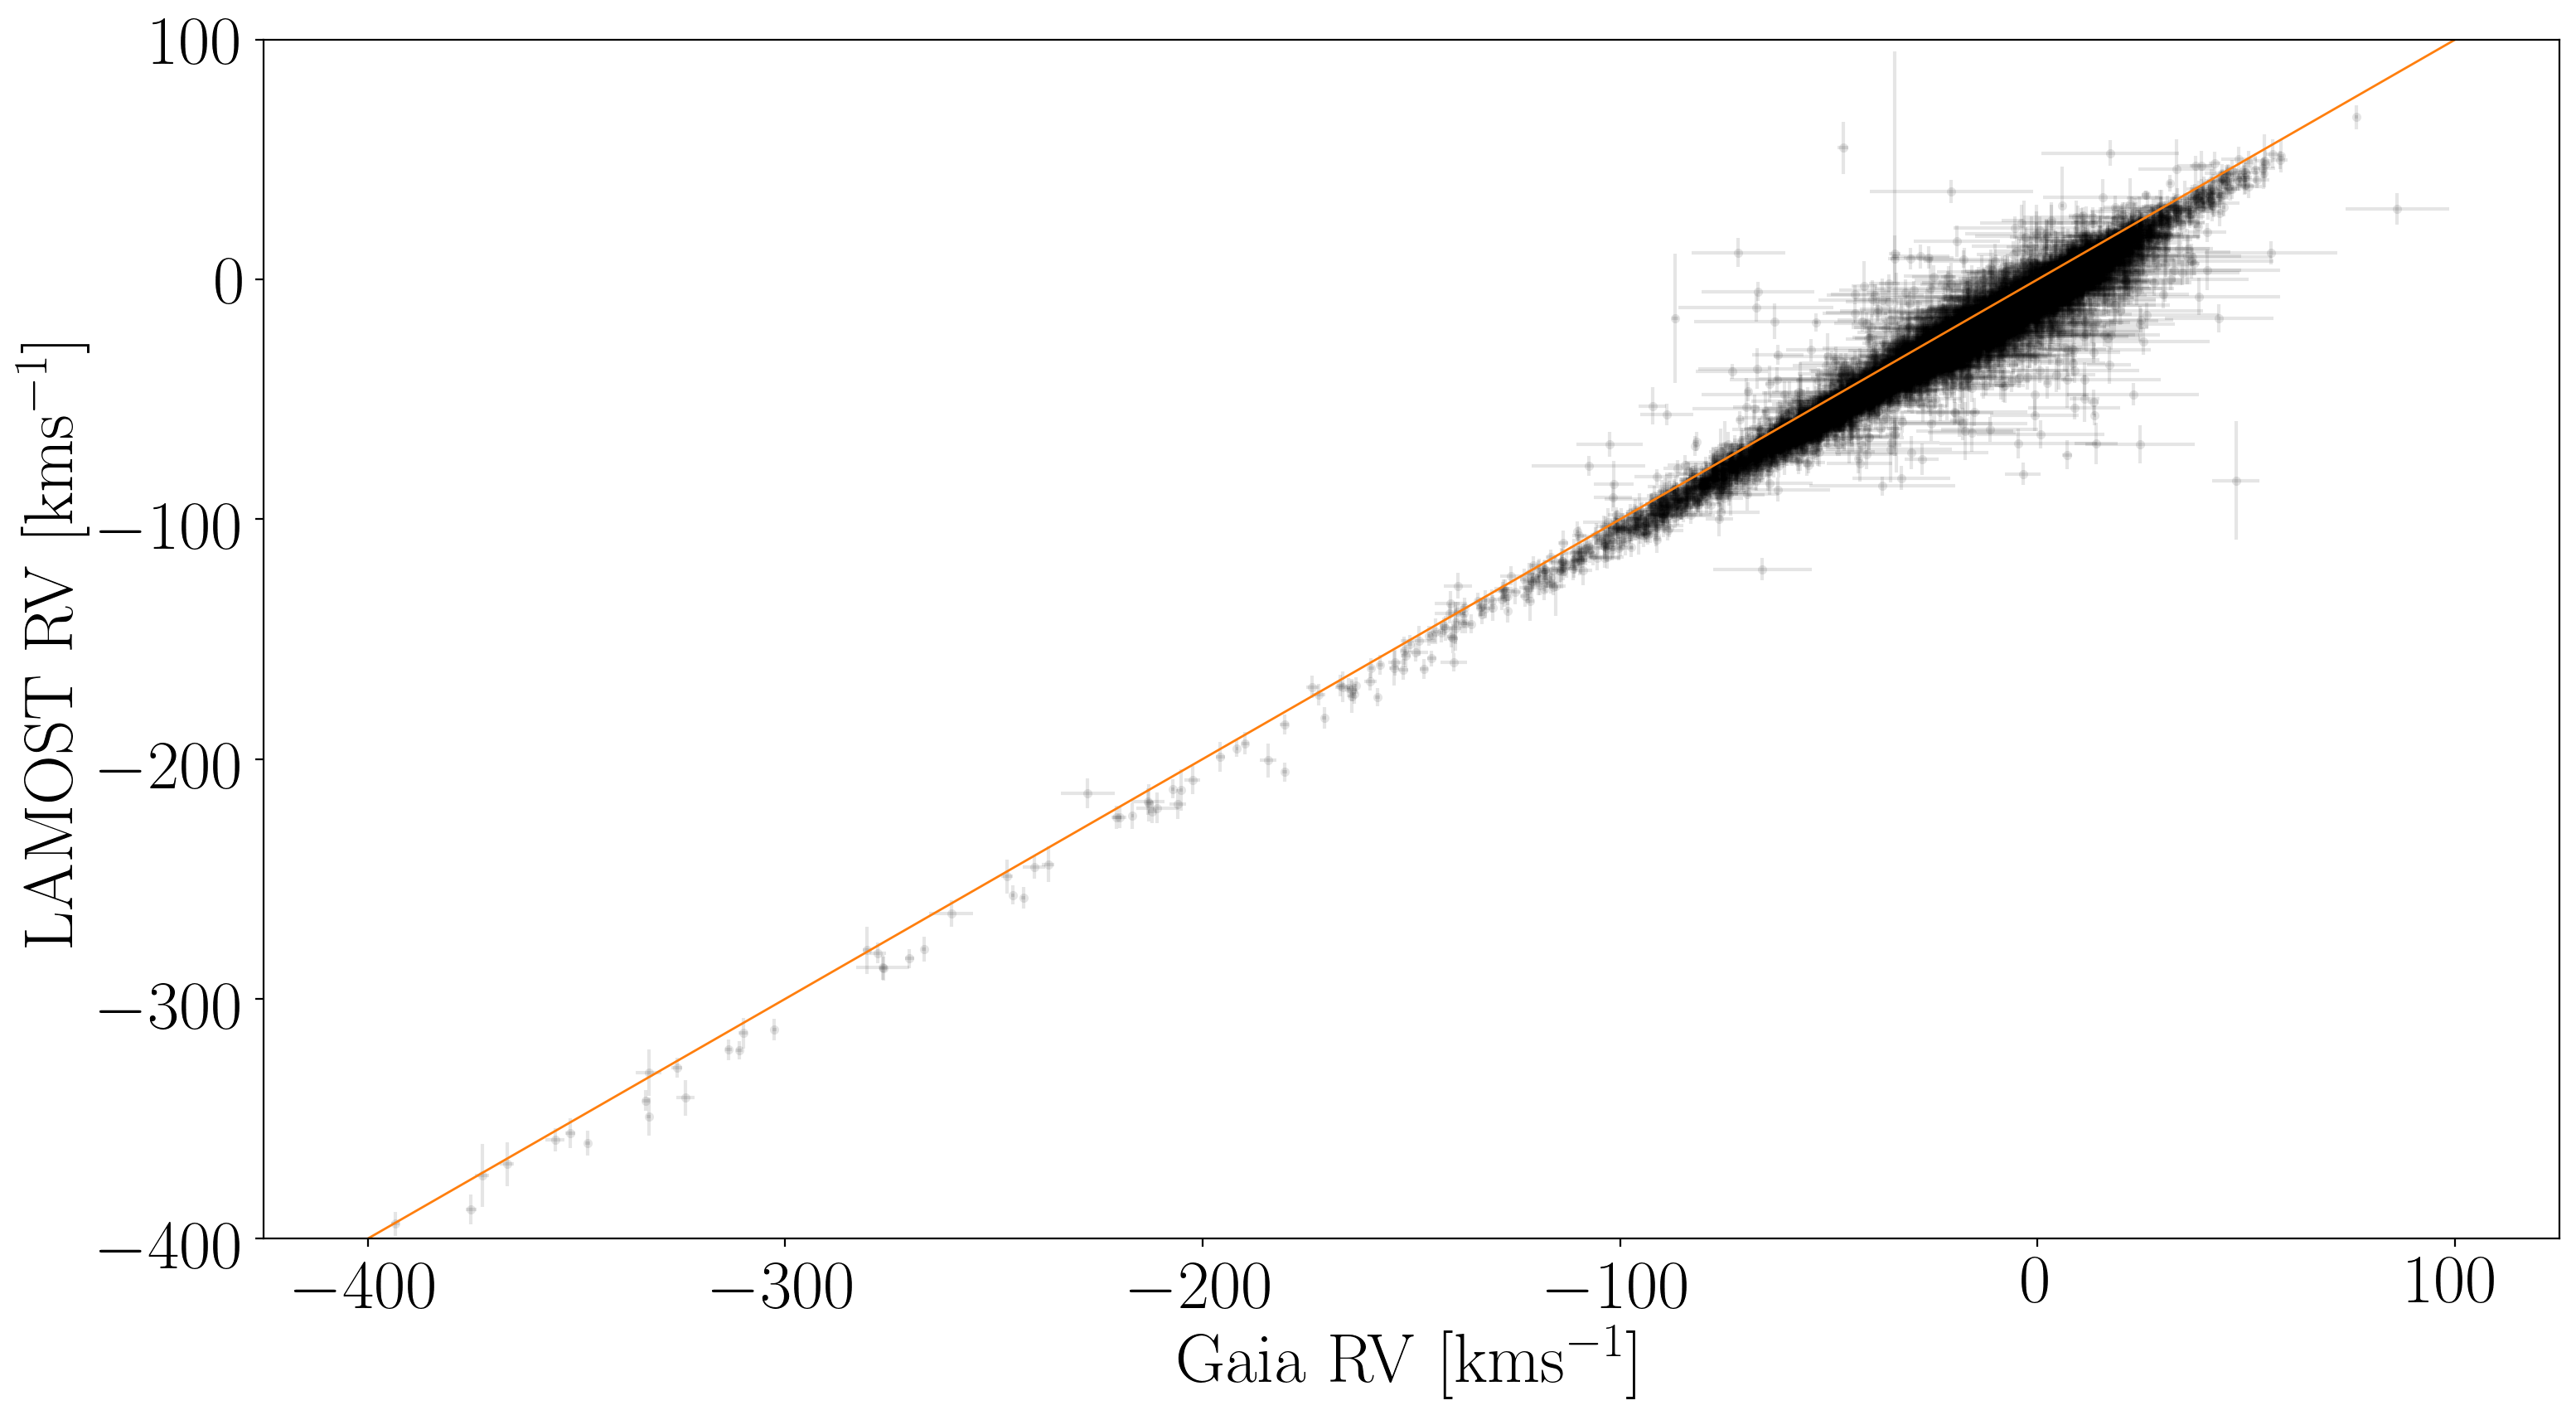

In [134]:
plotpar = {'axes.labelsize': 30,
                  'font.size': 22,
                  'legend.fontsize': 15,
                  'xtick.labelsize': 30,
                  'ytick.labelsize': 30,
                  'text.usetex': True}
plt.rcParams.update(plotpar)

m = np.isfinite(lamost_gaia.stellar_rv.values) & np.isfinite(lamost_gaia.radial_velocity.values) \
    & (lamost_gaia.radial_velocity.values != 0) & (abs(lamost_gaia.stellar_rv_err.values) < 100)
print(sum(m))

plt.figure(figsize=(16, 9), dpi=200)
plt.errorbar(lamost_gaia.radial_velocity.values[m], lamost_gaia.stellar_rv.values[m],
             xerr=lamost_gaia.radial_velocity_error.values[m],
             yerr=lamost_gaia.stellar_rv_err.values[m],
             fmt="k.", alpha=.1, ms=8, mec="none", zorder=0, rasterized=True)
xs = np.linspace(-400, 100, 100)
plt.plot(xs, xs, "C1", lw=1, zorder=1)
plt.ylim(-400, 100)
plt.xlabel("$\mathrm{Gaia~RV~[km s^{-1}]}$")
plt.ylabel("$\mathrm{LAMOST~RV~[km s^{-1}]}$")
plt.tight_layout()
plt.savefig("../plots/lamost_gaia_rvs")
plt.savefig("../plots/lamost_gaia_rvs.pdf")

1.0859441472482947 1.2325764133053378


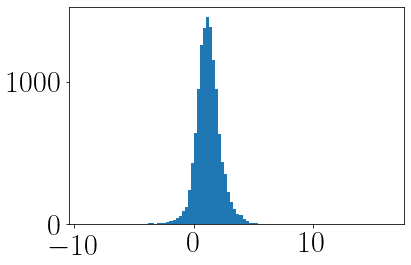

In [135]:
tot_err = np.sqrt(lamost_gaia.radial_velocity_error.values[m]**2 + lamost_gaia.stellar_rv_err.values[m]**2)
resids = lamost_gaia.radial_velocity.values[m] - lamost_gaia.stellar_rv.values[m]
plt.hist(resids/tot_err, 100);
print(np.std(resids/tot_err), np.mean(resids/tot_err))

Text(0.5, 0, 'RV uncertainty [km/s]')

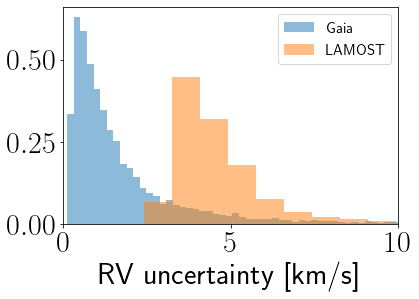

In [141]:
plt.hist(lamost_gaia.radial_velocity_error.values[m], 100, density=True, alpha=.5, label="Gaia");
plt.hist(lamost_gaia.stellar_rv_err.values[m], 100, density=True, alpha=.5, label="LAMOST");
plt.legend()
plt.xlim(0, 10)
plt.xlabel("RV uncertainty [km/s]")

Load the file output by data.py

In [142]:
df = pd.read_csv("../kepler_kinematics/gaia_kepler_lamost.csv")

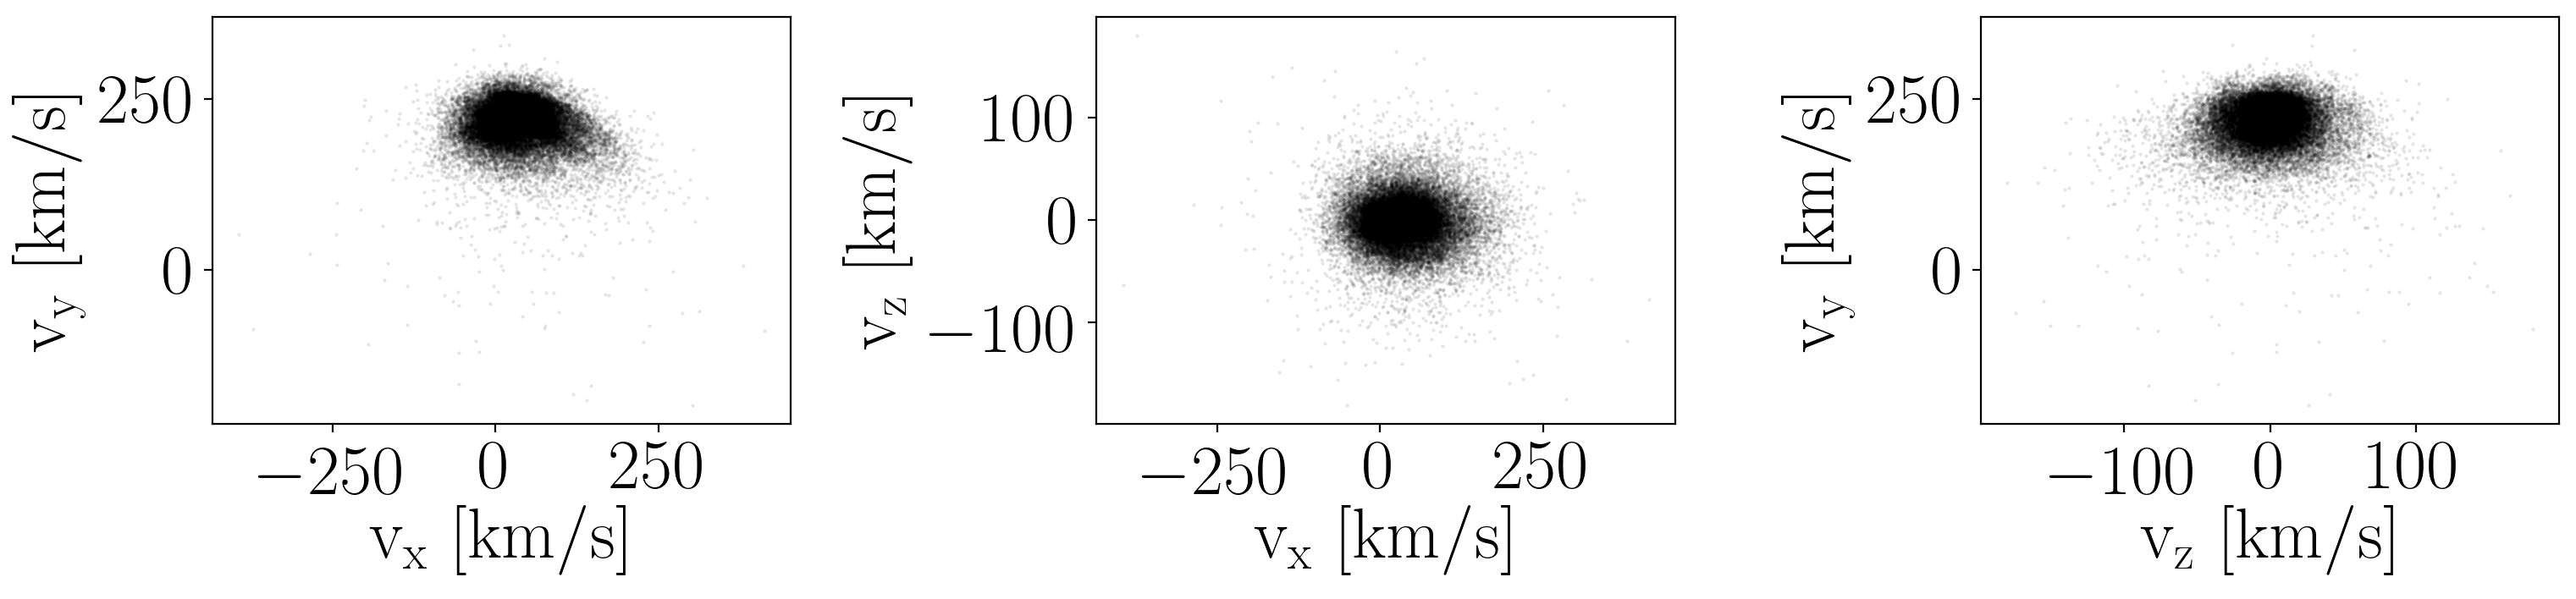

In [147]:
plotpar = {'axes.labelsize': 20,
                  'xtick.labelsize': 20,
                  'ytick.labelsize': 20,
                  'text.usetex': True}
plt.rcParams.update(plotpar)

fig = plt.figure(figsize=(16, 4), dpi=200)
ax0 = fig.add_subplot(131)
ax0.plot(df.vx, df.vy, "k.", ms=1, alpha=.1, rasterized=True)
ax0.set_xlabel("$\mathrm{v_x~[km/s]}$")
ax0.set_ylabel("$\mathrm{v_y~[km/s]}$")

ax1 = fig.add_subplot(132)
ax1.plot(df.vx, df.vz, "k.", ms=1, alpha=.1, rasterized=True)
ax1.set_xlabel("$\mathrm{v_x~[km/s]}$")
ax1.set_ylabel("$\mathrm{v_z~[km/s]}$")

ax1 = fig.add_subplot(133)
ax1.plot(df.vz, df.vy, "k.", ms=1, alpha=.1, rasterized=True)
ax1.set_xlabel("$\mathrm{v_z~[km/s]}$")
ax1.set_ylabel("$\mathrm{v_y~[km/s]}$")

plt.tight_layout()